=== ANALÝZA BLOG AUTHORSHIP CORPUS ===
Hledání 50 nejpodobnějších dvojic slov s min. 6 znaky
1. Načítání datasetu...
✓ Dataset načten: 681284 řádků, 7 sloupců
Sloupce: ['id', 'gender', 'age', 'topic', 'sign', 'date', 'text']

Základní informace o datasetu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB
None

Ukázka dat:
        id gender  age    topic sign         date  \
0  2059027   male   15  Student  Leo  14,May,2004   
1  2059027   male   15  Student  Leo  13,May,2004   
2  2059027   male   15  Student  Leo  12,May,2004   

                  

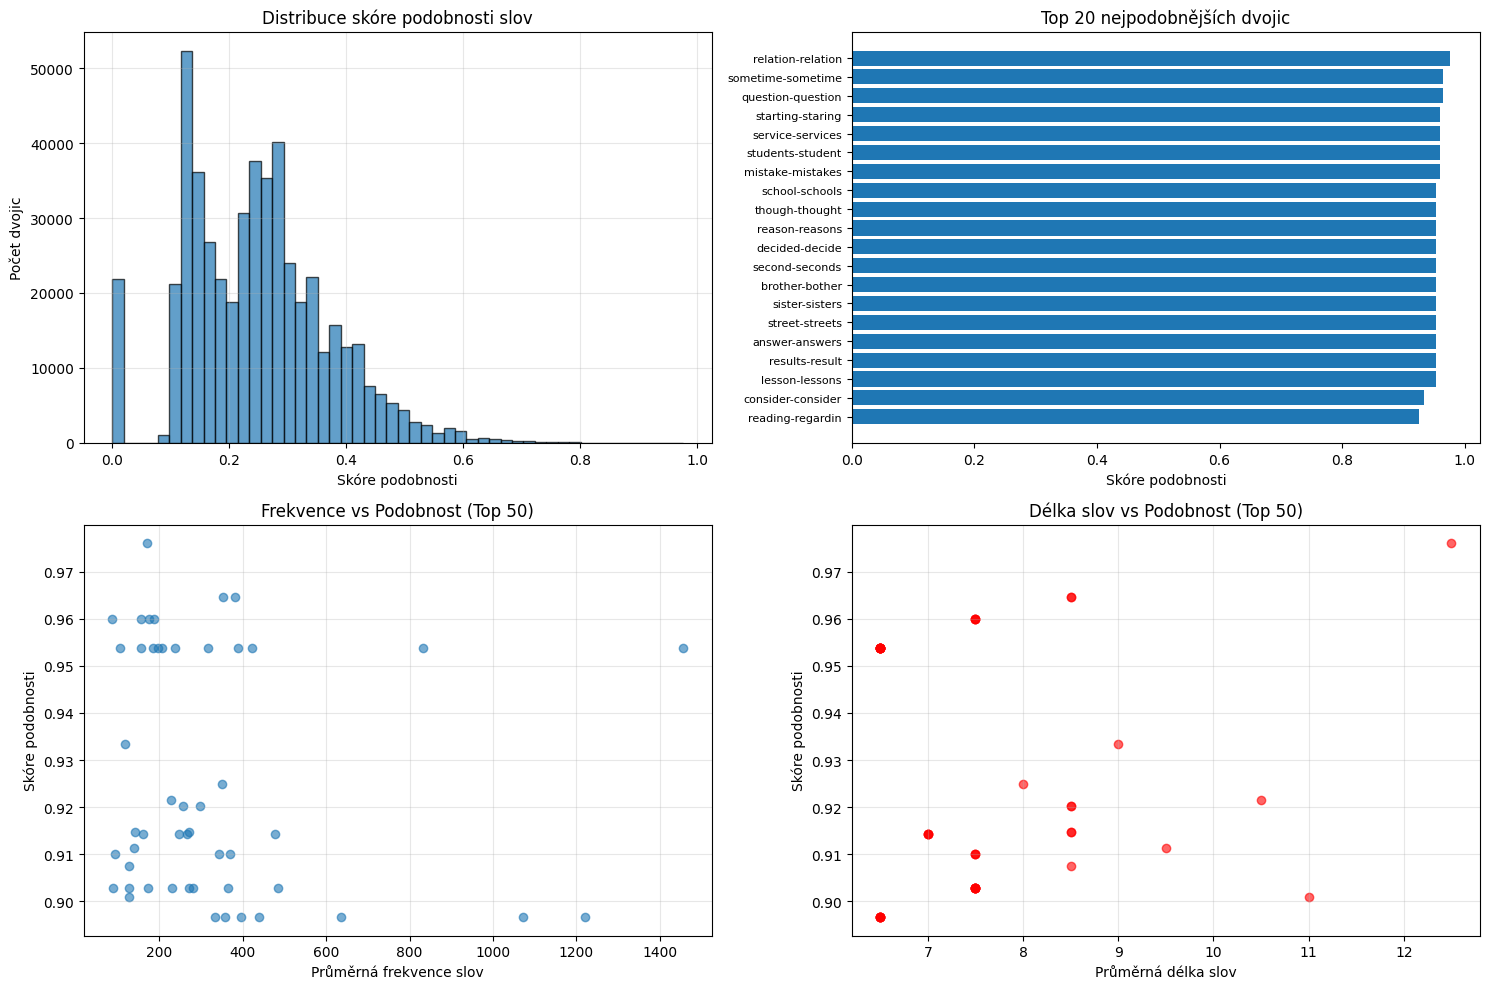


7. Export výsledků...
✓ Výsledky uloženy do 'top_50_podobnych_slov.csv'
✓ Statistiky uloženy do 'statistiky_podobnosti.csv'

ANALÝZA DOKONČENA!
Soubory vytvořené:
- top_50_podobnych_slov.csv
- statistiky_podobnosti.csv
- Grafy zobrazené výše

8. ZAJÍMAVÉ POZOROVÁNÍ:
-------------------------
Nejpodobnější dvojice: 'relationship' a 'relationships' (skóre: 0.9760)
Průměrná délka slov v top 10: 7.9 znaků
Nejčastější slovo v top 50 dvojicích: 'brother' (2x)

Analýza podobnosti slov dokončena!


In [12]:
# Blog Authorship Corpus - Analýza podobnosti slov
# Cíl: Najít 50 dvojic nejpodobnějších slov s minimálním počtem 6 znaků

import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
import warnings
warnings.filterwarnings('ignore')

# Nastavení pro lepší zobrazení
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')  # Změněno z 'seaborn-v0_8' kvůli kompatibilitě

print("=== ANALÝZA BLOG AUTHORSHIP CORPUS ===")
print("Hledání 50 nejpodobnějších dvojic slov s min. 6 znaky")
print("=" * 50)

# 1. NAČTENÍ DAT
print("1. Načítání datasetu...")
try:
    # Načtení Blog Authorship Corpus datasetu
    df = pd.read_csv('blogtext.csv')
    print(f"✓ Dataset načten: {df.shape[0]} řádků, {df.shape[1]} sloupců")
    print(f"Sloupce: {list(df.columns)}")
    
    # Zobrazení základních informací o datasetu
    print(f"\nZákladní informace o datasetu:")
    print(df.info())
    
    print(f"\nUkázka dat:")
    print(df.head(3))
    
    # Pokud dataset obsahuje sloupec 'text', použijeme ho
    text_column = None
    if 'text' in df.columns:
        text_column = 'text'
    elif any('text' in col.lower() for col in df.columns):
        text_column = [col for col in df.columns if 'text' in col.lower()][0]
    else:
        # Pokud není jasný textový sloupec, vezmeme první string sloupec
        string_columns = df.select_dtypes(include=['object']).columns
        if len(string_columns) > 0:
            text_column = string_columns[0]
    
    # Ověření existence textového sloupce
    if text_column is None:
        print("❌ Nepodařilo se najít textový sloupec v datasetu!")
        print("Dostupné sloupce:", list(df.columns))
        print("Ukončuji program...")
        exit()

    print(f"Používaný textový sloupec: '{text_column}'")
    
    # Pro rychlejší zpracování použijeme pouze vzorek dat (pokud je dataset velmi velký)
    if len(df) > 10000:
        print(f"Dataset je velký ({len(df)} řádků), používáme vzorek 10,000 řádků...")
        df_sample = df.sample(n=10000, random_state=42)
    else:
        df_sample = df.copy()
    
    # Ověření, že máme data k analýze
    if df_sample[text_column].isna().all():
        print("❌ Textový sloupec neobsahuje žádná data!")
        print("Ukončuji program...")
        exit()
    
    # Odstranění řádků s chybějícími textovými daty
    original_size = len(df_sample)
    df_sample = df_sample.dropna(subset=[text_column])
    if len(df_sample) == 0:
        print("❌ Po odstranění prázdných řádků nezůstala žádná data!")
        print("Ukončuji program...")
        exit()
    
    if len(df_sample) < original_size:
        print(f"Odstraněno {original_size - len(df_sample)} řádků s chybějícími daty")
    
    print(f"Finální pracovní dataset: {df_sample.shape[0]} řádků")
    
except FileNotFoundError:
    print("❌ Soubor 'blogtext.csv' nebyl nalezen!")
    print("Postup pro získání dat:")
    print("1. Registrujte se na Kaggle.com")
    print("2. Stáhněte dataset z: https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus")
    print("3. Rozbalte a umístěte soubor 'blogtext.csv' do stejné složky jako tento skript")
    print("\n❌ CHYBA: Bez souboru 'blogtext.csv' nelze pokračovat!")
    print("Ukončuji program...")
    exit()
except Exception as e:
    print(f"❌ Chyba při načítání souboru: {e}")
    print("Ukončuji program...")
    exit()

# 2. PŘÍPRAVA TEXTU A EXTRAKCE SLOV
print("\n2. Příprava textu a extrakce slov...")

def clean_and_extract_words(text):
    """Vyčistí text a extrahuje slova s min. 6 znaky"""
    if pd.isna(text) or not isinstance(text, str):
        return []
    
    # Převod na malá písmena a odstranění speciálních znaků
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Extrakce slov s min. 6 znaky
    words = [word.strip() for word in text.split() if len(word.strip()) >= 6]
    return words

# Extrakce všech slov z datasetu
print("Extrahování slov z textů...")
all_words = []
for i, text in enumerate(df_sample[text_column]):
    if i % 1000 == 0:
        print(f"  Zpracováno {i}/{len(df_sample)} textů...")
    words = clean_and_extract_words(text)
    all_words.extend(words)

print(f"✓ Celkem extrahováno slov: {len(all_words)}")

# Počítání frekvence slov
word_counts = Counter(all_words)
print(f"✓ Unikátních slov (≥6 znaků): {len(word_counts)}")

# Zobrazení nejčastějších slov
print(f"\n10 nejčastějších slov:")
for word, count in word_counts.most_common(10):
    print(f"  {word}: {count}")

# Filtrování slov s minimální frekvencí (pro rychlejší zpracování)
min_frequency = 3
filtered_words = [word for word, count in word_counts.items() if count >= min_frequency]
print(f"✓ Slov s frekvencí ≥{min_frequency}: {len(filtered_words)}")

# Omezení na maximálně 1000 slov pro rychlejší zpracování
if len(filtered_words) > 1000:
    # Vybereme 1000 nejčastějších slov
    top_words = [word for word, count in word_counts.most_common(1000) if count >= min_frequency]
    filtered_words = top_words[:1000]
    print(f"✓ Omezeno na {len(filtered_words)} nejčastějších slov pro zpracování")

# 3. VÝPOČET PODOBNOSTI SLOV
print("\n3. Výpočet podobnosti slov...")

def similarity_score(word1, word2):
    """Vypočítá skóre podobnosti mezi dvěma slovy pomocí několika metrik"""
    # Jaccardova podobnost (průnik/sjednocení znaků)
    set1, set2 = set(word1), set(word2)
    jaccard = len(set1 & set2) / len(set1 | set2)
    
    # Levenshteinova podobnost
    leven = SequenceMatcher(None, word1, word2).ratio()
    
    # Kombinované skóre (vážený průměr)
    combined = 0.4 * jaccard + 0.6 * leven
    return combined

# Výpočet podobnosti pro všechny dvojice slov
print("Počítání podobnosti mezi slovy...")
similarities = []
total_pairs = len(list(combinations(filtered_words, 2)))
print(f"Celkem dvojic k vyhodnocení: {total_pairs}")

for i, (word1, word2) in enumerate(combinations(filtered_words, 2)):
    if i % 10000 == 0:
        print(f"  Zpracováno {i}/{total_pairs} dvojic...")

    # Přeskočíme páry s identickými slovy
    if word1 == word2:
        continue
    
    sim_score = similarity_score(word1, word2)
    similarities.append((word1, word2, sim_score))

# Seřazení podle podobnosti
similarities.sort(key=lambda x: x[2], reverse=True)

print(f"✓ Podobnost vypočítána pro {len(similarities)} dvojic slov")

# 4. VÝSLEDKY - TOP 50 NEJPODOBNĚJŠÍCH DVOJIC
print("\n4. TOP 50 NEJPODOBNĚJŠÍCH DVOJIC SLOV")
print("=" * 60)

print(f"{'Rank':<4} {'Slovo 1':<15} {'Slovo 2':<15} {'Podobnost':<10} {'Freq1':<6} {'Freq2':<6}")
print("-" * 60)

top_50_similarities = similarities[:50]
for i, (word1, word2, score) in enumerate(top_50_similarities, 1):
    freq1 = word_counts[word1]
    freq2 = word_counts[word2]
    print(f"{i:<4} {word1:<15} {word2:<15} {score:.4f}    {freq1:<6} {freq2:<6}")

# 5. STATISTICKÁ ANALÝZA
print("\n5. STATISTICKÁ ANALÝZA")
print("=" * 30)

scores = [sim[2] for sim in similarities]
print(f"Průměrná podobnost: {np.mean(scores):.4f}")
print(f"Medián podobnosti: {np.median(scores):.4f}")
print(f"Standardní odchylka: {np.std(scores):.4f}")
print(f"Minimum: {np.min(scores):.4f}")
print(f"Maximum: {np.max(scores):.4f}")

# 6. VIZUALIZACE
print("\n6. Vytváření grafů...")

# Graf 1: Histogram distribuce podobnosti
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(scores, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribuce skóre podobnosti slov')
plt.xlabel('Skóre podobnosti')
plt.ylabel('Počet dvojic')
plt.grid(True, alpha=0.3)

# Graf 2: Top 20 nejpodobnějších dvojic
plt.subplot(2, 2, 2)
top_20_words = [f"{sim[0][:8]}-{sim[1][:8]}" for sim in similarities[:20]]
top_20_scores = [sim[2] for sim in similarities[:20]]

plt.barh(range(len(top_20_words)), top_20_scores)
plt.yticks(range(len(top_20_words)), top_20_words, fontsize=8)
plt.xlabel('Skóre podobnosti')
plt.title('Top 20 nejpodobnějších dvojic')
plt.gca().invert_yaxis()

# Graf 3: Frekvence vs podobnost (pro top 50)
plt.subplot(2, 2, 3)
freqs1 = [word_counts[sim[0]] for sim in top_50_similarities]
freqs2 = [word_counts[sim[1]] for sim in top_50_similarities]
avg_freqs = [(f1 + f2) / 2 for f1, f2 in zip(freqs1, freqs2)]
top_50_scores = [sim[2] for sim in top_50_similarities]

plt.scatter(avg_freqs, top_50_scores, alpha=0.6)
plt.xlabel('Průměrná frekvence slov')
plt.ylabel('Skóre podobnosti')
plt.title('Frekvence vs Podobnost (Top 50)')
plt.grid(True, alpha=0.3)

# Graf 4: Délka slov vs podobnost
plt.subplot(2, 2, 4)
word_lengths = [(len(sim[0]) + len(sim[1])) / 2 for sim in top_50_similarities]
plt.scatter(word_lengths, top_50_scores, alpha=0.6, color='red')
plt.xlabel('Průměrná délka slov')
plt.ylabel('Skóre podobnosti')
plt.title('Délka slov vs Podobnost (Top 50)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. EXPORT VÝSLEDKŮ
print("\n7. Export výsledků...")

# Vytvoření DataFrame s výsledky
results_df = pd.DataFrame([
    {
        'rank': i + 1,
        'word1': sim[0],
        'word2': sim[1],
        'similarity_score': sim[2],
        'word1_frequency': word_counts[sim[0]],
        'word2_frequency': word_counts[sim[1]],
        'avg_frequency': (word_counts[sim[0]] + word_counts[sim[1]]) / 2,
        'word1_length': len(sim[0]),
        'word2_length': len(sim[1]),
        'avg_length': (len(sim[0]) + len(sim[1])) / 2
    }
    for i, sim in enumerate(top_50_similarities)
])

# Uložení do CSV
results_df.to_csv('top_50_podobnych_slov.csv', index=False, encoding='utf-8')
print("✓ Výsledky uloženy do 'top_50_podobnych_slov.csv'")

# Uložení kompletních statistik
stats_dict = {
    'total_words_extracted': len(all_words),
    'unique_words': len(word_counts),
    'filtered_words': len(filtered_words),
    'total_pairs_evaluated': len(similarities),
    'mean_similarity': np.mean(scores),
    'median_similarity': np.median(scores),
    'std_similarity': np.std(scores),
    'min_similarity': np.min(scores),
    'max_similarity': np.max(scores)
}

stats_df = pd.DataFrame([stats_dict])
stats_df.to_csv('statistiky_podobnosti.csv', index=False, encoding='utf-8')
print("✓ Statistiky uloženy do 'statistiky_podobnosti.csv'")

print("\n" + "=" * 50)
print("ANALÝZA DOKONČENA!")
print("=" * 50)
print("Soubory vytvořené:")
print("- top_50_podobnych_slov.csv")
print("- statistiky_podobnosti.csv")
print("- Grafy zobrazené výše")

# 8. ZAJÍMAVÉ POZOROVÁNÍ
print("\n8. ZAJÍMAVÉ POZOROVÁNÍ:")
print("-" * 25)

# Nejpodobnější dvojice
best_pair = similarities[0]
print(f"Nejpodobnější dvojice: '{best_pair[0]}' a '{best_pair[1]}' (skóre: {best_pair[2]:.4f})")

# Průměrná délka slov v top 10
top_10_lengths = [(len(sim[0]) + len(sim[1])) / 2 for sim in similarities[:10]]
print(f"Průměrná délka slov v top 10: {np.mean(top_10_lengths):.1f} znaků")

# Nejčastěji se vyskytující slova v top 50
all_top50_words = []
for sim in top_50_similarities:
    all_top50_words.extend([sim[0], sim[1]])
top50_word_counts = Counter(all_top50_words)
print(f"Nejčastější slovo v top 50 dvojicích: '{top50_word_counts.most_common(1)[0][0]}' ({top50_word_counts.most_common(1)[0][1]}x)")

print("\nAnalýza podobnosti slov dokončena!")